[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -U --no-cache-dir gdown --pre

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

Downloading...
From: https://drive.google.com/uc?id=1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK
To: /Users/yvesgreatti/github/2023-Experiments/data.tar.gz
100%|██████████| 1.31G/1.31G [00:16<00:00, 77.7MB/s]


In [23]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage i.e. 90%

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformalized Quantile Regression

In [11]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, method='higher')
prediction_sets = val_smx >= (1-qhat) # 3: form prediction sets

In [12]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.8878163265306123


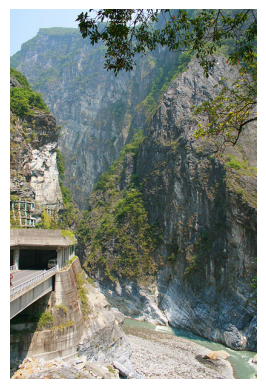

The prediction set is: ['dam', 'alp', 'cliff', 'valley']


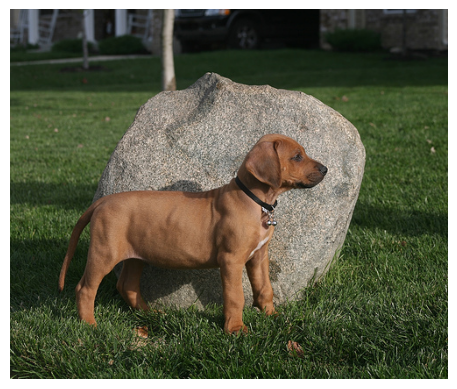

The prediction set is: ['Rhodesian Ridgeback', 'Redbone Coonhound']


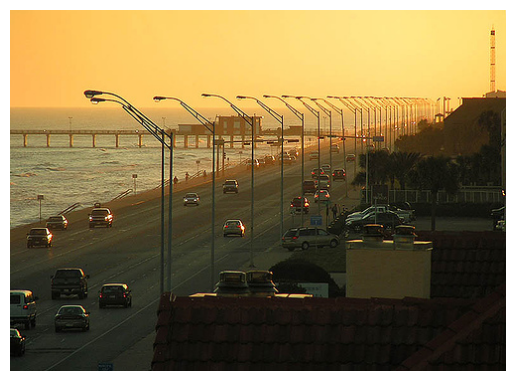

The prediction set is: ['baluster', 'greenhouse']


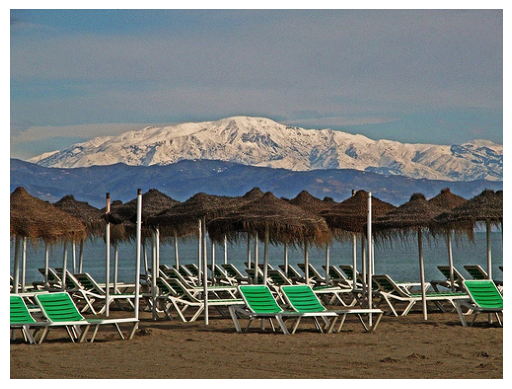

The prediction set is: ['folding chair', 'rocking chair', 'thatched roof', 'split-rail fence']


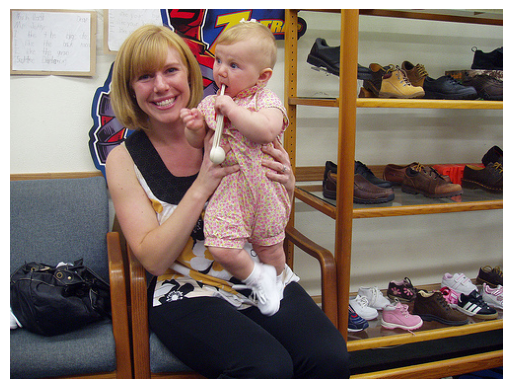

The prediction set is: ['shoe store']


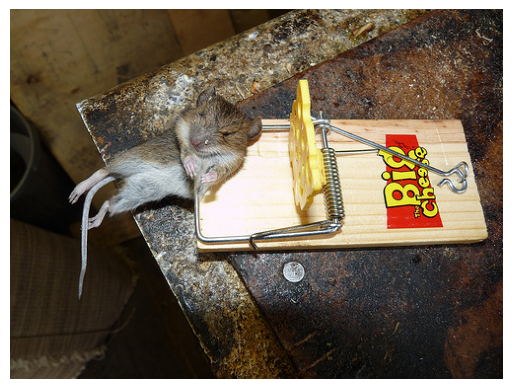

The prediction set is: ['mousetrap']


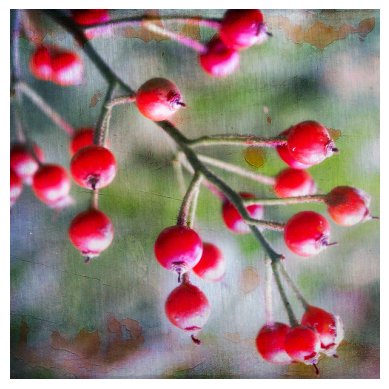

The prediction set is: ['rose hip']


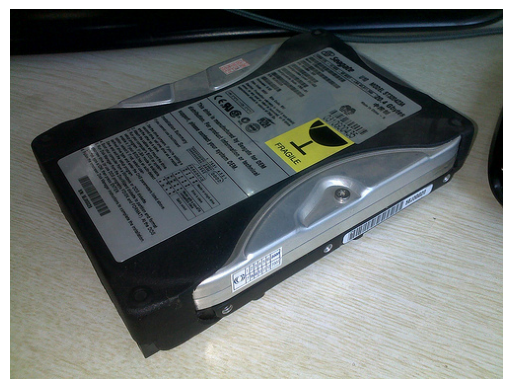

The prediction set is: ['hard disk drive']


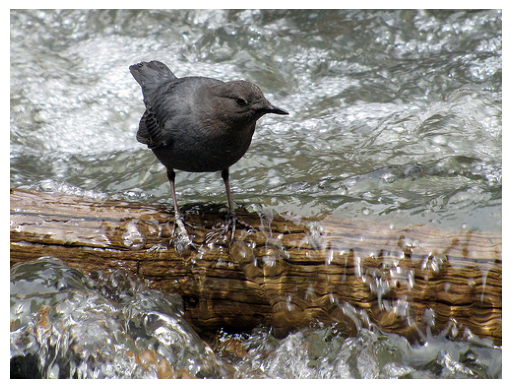

The prediction set is: ['American dipper']


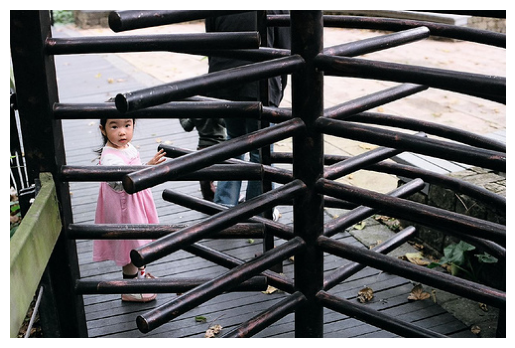

The prediction set is: ['turnstile']


In [13]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")